<a href="https://colab.research.google.com/github/eugeqq/Protocolos/blob/main/MyS_TP7_Regresi%C3%B3n_Lineal_Multiple__R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Lineal Múltiple

Escenario: Análisis del Mercado Inmobiliario

Una inmobiliara desea desarrollar un modelo predictivo para estimar el precio de venta de propiedades en la ciudad. Para ello, ha recolectado información histórica de 100 ventas recientes, incluyendo las siguientes características:
- Superficie total del inmueble ($m^2$)
- Número de habitaciones
- Antigüedad de la propiedad (años)
- Distancia al centro de la ciudad (km)
- Superficie cubierta ($m^2$)

OBJETIVOS:
1. Constriur un modelo de regresión lienal múltiple que permita predecir el precio de venta a partir de las características de la propiedad
2. Realizar un análisis exploratorio para identificar relaciones entre variables y detectar posibles problemas de multicolinealidad
3. Evaluar la calidad del modelo mediante:
  - Coeficiente de determinación ($R^2$ y $R^2$ ajustado)
  - Descomposición de la varianza (SST, SSR, SSE)
4. Detectar y corregir problemas de multicolinealidad mediante:
  - Matriz de correlación entre predictores
  - Cálculo del Factor de Inflación de la Varianza (VIF)
  - Eliminación de variables redundantes
5. Comparar diferentes técnicas de regularización (Ridge y Lasso) para mejorar la estabilidad del modelo
6. Interpretar los coeficientes del modelo final y validar los supuestos de la regresión lineal

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("EJERCICIO: PREDICCIÓN DE PRECIOS DE CASAS")
print("="*70)

EJERCICIO: PREDICCIÓN DE PRECIOS DE CASAS


In [ ]:
# ============================================================================
# PARTE 1: GENERACIÓN DE DATOS CON MULTICOLINEALIDAD
# ============================================================================
print("\n1. GENERACIÓN DE DATOS")
print("-"*70)

np.random.seed(42)
n = 100  # número de observaciones

# Variables independientes
superficie = np.random.uniform(50, 300, n)  # m²
habitaciones = 1 + superficie/50 + np.random.normal(0, 0.5, n)  # Colineal con superficie
antiguedad = np.random.uniform(0, 50, n)  # años
distancia_centro = np.random.uniform(1, 30, n)  # km
# Variable adicional muy colineal con superficie
superficie_cubierta = superficie * 0.85 + np.random.normal(0, 5, n)

# Variable dependiente: Precio (con relación real)
precio = (2000*superficie + 5000*habitaciones - 1000*antiguedad
          - 500*distancia_centro + 50000 + np.random.normal(0, 20000, n))

# Crear DataFrame
df = pd.DataFrame({
    'Superficie': superficie,
    'Habitaciones': habitaciones,
    'Antiguedad': antiguedad,
    'Distancia_Centro': distancia_centro,
    'Superficie_Cubierta': superficie_cubierta,
    'Precio': precio
})

print(f"Dataset generado: {n} observaciones")
print(f"\nPrimeras filas:\n{df.head()}")
print(f"\nEstadísticas descriptivas:\n{df.describe()}")



1. GENERACIÓN DE DATOS
----------------------------------------------------------------------
Dataset generado: 100 observaciones

Primeras filas:
   Superficie  Habitaciones  Antiguedad  Distancia_Centro  \
0  143.635030      3.916224   39.740565         11.323208   
1  287.678577      6.604068   25.131855         22.977537   
2  232.998485      5.705850   28.845194          1.417411   
3  199.664621      3.999508   24.625885          4.366107   
4   89.004660      2.670257    9.762149          2.334077   

   Superficie_Cubierta         Precio  
0           124.154433  277381.362261  
1           241.708167  620645.915254  
2           193.937611  522653.630555  
3           170.933364  441863.948977  
4            76.878794  189082.576813  

Estadísticas descriptivas:
       Superficie  Habitaciones  Antiguedad  Distancia_Centro  \
count  100.000000    100.000000  100.000000        100.000000   
mean   167.545186      4.350364   26.414614         15.335109   
std     74.372353     

In [ ]:
# ============================================================================
# PARTE 2: ANÁLISIS EXPLORATORIO
# ============================================================================
print("\n\n2. ANÁLISIS EXPLORATORIO")
print("-"*70)

# Matriz de correlación
correlation_matrix = df.corr()
print("\nMatriz de correlación:")
print(correlation_matrix.round(3))

# Identificar variables colineales
print("\n⚠️  DETECCIÓN DE COLINEALIDAD (|r| > 0.8):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if i != j:
            corr_val = abs(correlation_matrix.iloc[i, j])
            if corr_val > 0.8:
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                print(f"  • {var1} ↔ {var2}: r = {correlation_matrix.iloc[i, j]:.3f}")




2. ANÁLISIS EXPLORATORIO
----------------------------------------------------------------------

Matriz de correlación:
                     Superficie  Habitaciones  Antiguedad  Distancia_Centro  \
Superficie                1.000         0.953      -0.029             0.050   
Habitaciones              0.953         1.000      -0.001             0.088   
Antiguedad               -0.029        -0.001       1.000            -0.058   
Distancia_Centro          0.050         0.088      -0.058             1.000   
Superficie_Cubierta       0.997         0.949      -0.033             0.057   
Precio                    0.990         0.943      -0.097             0.023   

                     Superficie_Cubierta  Precio  
Superficie                         0.997   0.990  
Habitaciones                       0.949   0.943  
Antiguedad                        -0.033  -0.097  
Distancia_Centro                   0.057   0.023  
Superficie_Cubierta                1.000   0.988  
Precio            

In [ ]:
# ============================================================================
# PARTE 3: MODELO DE REGRESIÓN INICIAL (CON MULTICOLINEALIDAD)
# ============================================================================
print("\n\n3. MODELO INICIAL (Con todas las variables)")
print("-"*70)

# Preparar datos
X = df[['Superficie', 'Habitaciones', 'Antiguedad', 'Distancia_Centro', 'Superficie_Cubierta']]
y = df['Precio']

# Ajustar modelo
model_inicial = LinearRegression()
model_inicial.fit(X, y)
y_pred_inicial = model_inicial.predict(X)

# Métricas
r2_inicial = r2_score(y, y_pred_inicial)
mse_inicial = mean_squared_error(y, y_pred_inicial)
rmse_inicial = np.sqrt(mse_inicial)

print(f"\nCoeficientes del modelo:")
for i, col in enumerate(X.columns):
    print(f"  β_{i+1} ({col:20s}): {model_inicial.coef_[i]:12.2f}")
print(f"  β_0 (Intercepto)        : {model_inicial.intercept_:12.2f}")

print(f"\nMétricas del modelo:")
print(f"  R² = {r2_inicial:.4f}")
print(f"  RMSE = ${rmse_inicial:,.2f}")

# Calcular R² ajustado
n_obs = len(y)
p_vars = X.shape[1]
r2_adj_inicial = 1 - (1 - r2_inicial) * (n_obs - 1) / (n_obs - p_vars - 1)
print(f"  R² ajustado = {r2_adj_inicial:.4f}")




3. MODELO INICIAL (Con todas las variables)
----------------------------------------------------------------------

Coeficientes del modelo:
  β_1 (Superficie          ):      1481.81
  β_2 (Habitaciones        ):      4168.61
  β_3 (Antiguedad          ):      -768.21
  β_4 (Distancia_Centro    ):      -608.01
  β_5 (Superficie_Cubierta ):       630.45
  β_0 (Intercepto)        :     41650.78

Métricas del modelo:
  R² = 0.9856
  RMSE = $18,795.06
  R² ajustado = 0.9848




4. ANÁLISIS DE MULTICOLINEALIDAD - VIF
----------------------------------------------------------------------

Interpretación:
  VIF = 1      : No hay colinealidad
  VIF = 1-5    : Colinealidad moderada
  VIF > 5-10   : Colinealidad alta (revisar)
  VIF > 10     : Colinealidad severa (eliminar variable)

           Variable         VIF
         Superficie 1042.614256
Superficie_Cubierta  992.257934
       Habitaciones   78.468347
   Distancia_Centro    3.767065
         Antiguedad    3.658125


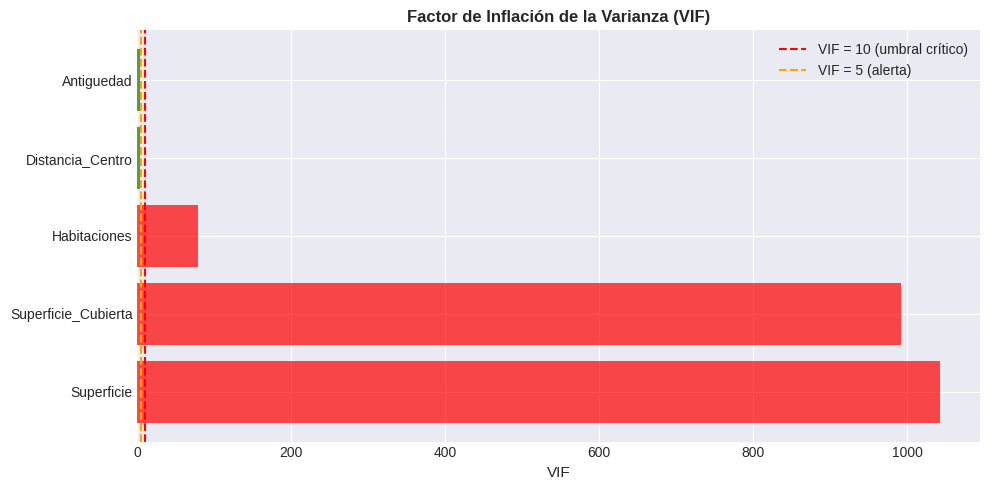

In [ ]:
# ============================================================================
# PARTE 4: CÁLCULO DE VIF (Variance Inflation Factor)
# ============================================================================
print("\n\n4. ANÁLISIS DE MULTICOLINEALIDAD - VIF")
print("-"*70)
print("\nInterpretación:")
print("  VIF = 1      : No hay colinealidad")
print("  VIF = 1-5    : Colinealidad moderada")
print("  VIF > 5-10   : Colinealidad alta (revisar)")
print("  VIF > 10     : Colinealidad severa (eliminar variable)")

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(f"\n{vif_data.to_string(index=False)}")

# Visualizar VIF
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_data['VIF']]
ax.barh(vif_data['Variable'], vif_data['VIF'], color=colors, alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', label='VIF = 10 (umbral crítico)')
ax.axvline(x=5, color='orange', linestyle='--', label='VIF = 5 (alerta)')
ax.set_xlabel('VIF', fontsize=11)
ax.set_title('Factor de Inflación de la Varianza (VIF)', fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# PARTE 5: MODELO CORREGIDO (SIN MULTICOLINEALIDAD)
# ============================================================================
print("\n\n5. MODELO CORREGIDO (Eliminando Superficie_Cubierta)")
print("-"*70)

# Eliminar variable con VIF alto
X_corregido = df[['Superficie', 'Habitaciones', 'Antiguedad', 'Distancia_Centro']]

# Ajustar modelo
model_corregido = LinearRegression()
model_corregido.fit(X_corregido, y)
y_pred_corregido = model_corregido.predict(X_corregido)

# Métricas
r2_corregido = r2_score(y, y_pred_corregido)
rmse_corregido = np.sqrt(mean_squared_error(y, y_pred_corregido))
r2_adj_corregido = 1 - (1 - r2_corregido) * (n_obs - 1) / (n_obs - X_corregido.shape[1] - 1)

print(f"\nCoeficientes del modelo corregido:")
for i, col in enumerate(X_corregido.columns):
    print(f"  β_{i+1} ({col:20s}): {model_corregido.coef_[i]:12.2f}")
print(f"  β_0 (Intercepto)        : {model_corregido.intercept_:12.2f}")

print(f"\nMétricas del modelo corregido:")
print(f"  R² = {r2_corregido:.4f}")
print(f"  R² ajustado = {r2_adj_corregido:.4f}")
print(f"  RMSE = ${rmse_corregido:,.2f}")

# Nuevo VIF
vif_corregido = pd.DataFrame()
vif_corregido["Variable"] = X_corregido.columns
vif_corregido["VIF"] = [variance_inflation_factor(X_corregido.values, i)
                        for i in range(X_corregido.shape[1])]
print(f"\nVIF después de corrección:\n{vif_corregido.to_string(index=False)}")



5. MODELO CORREGIDO (Eliminando Superficie_Cubierta)
----------------------------------------------------------------------

Coeficientes del modelo corregido:
  β_1 (Superficie          ):      2018.97
  β_2 (Habitaciones        ):      3944.89
  β_3 (Antiguedad          ):      -779.72
  β_4 (Distancia_Centro    ):      -575.24
  β_0 (Intercepto)        :     42462.28

Métricas del modelo corregido:
  R² = 0.9852
  R² ajustado = 0.9846
  RMSE = $19,051.65

VIF después de corrección:
        Variable       VIF
      Superficie 60.453637
    Habitaciones 78.468327
      Antiguedad  3.655086
Distancia_Centro  3.714792




6. DESCOMPOSICIÓN DE LA VARIANZA
----------------------------------------------------------------------

SST (Suma de Cuadrados Total)     = 2,454,184,613,722.46
SSR (Suma de Cuadrados Regresión) = 2,417,888,070,679.02
SSE (Suma de Cuadrados Error)     = 36,296,543,043.45

Verificación: SST = SSR + SSE
  2,454,184,613,722.46 = 2,417,888,070,679.02 + 36,296,543,043.45
  Diferencia: 0.00 ≈ 0 ✓

Proporción de varianza explicada:
  SSR/SST = 0.9852 = R² = 0.9852 ✓


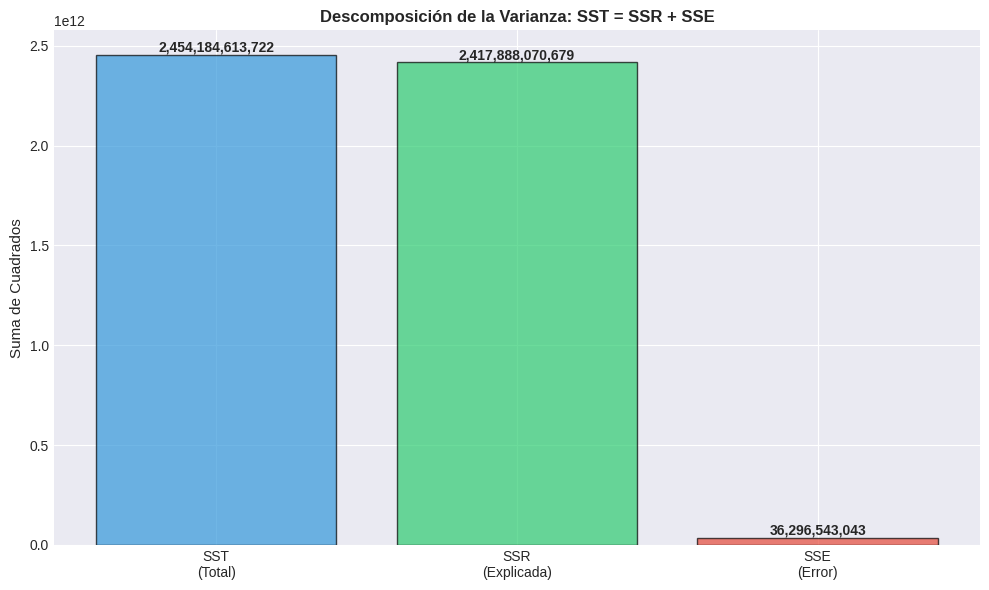

In [ ]:
# ============================================================================
# PARTE 6: DESCOMPOSICIÓN DE LA VARIANZA (SST, SSR, SSE)
# ============================================================================
print("\n\n6. DESCOMPOSICIÓN DE LA VARIANZA")
print("-"*70)

y_mean = np.mean(y)
SST = np.sum((y - y_mean)**2)
SSR = np.sum((y_pred_corregido - y_mean)**2)
SSE = np.sum((y - y_pred_corregido)**2)

print(f"\nSST (Suma de Cuadrados Total)     = {SST:,.2f}")
print(f"SSR (Suma de Cuadrados Regresión) = {SSR:,.2f}")
print(f"SSE (Suma de Cuadrados Error)     = {SSE:,.2f}")
print(f"\nVerificación: SST = SSR + SSE")
print(f"  {SST:,.2f} = {SSR:,.2f} + {SSE:,.2f}")
print(f"  Diferencia: {abs(SST - (SSR + SSE)):,.2f} ≈ 0 ✓")

print(f"\nProporción de varianza explicada:")
print(f"  SSR/SST = {SSR/SST:.4f} = R² = {r2_corregido:.4f} ✓")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
variance_components = [SST, SSR, SSE]
labels = ['SST\n(Total)', 'SSR\n(Explicada)', 'SSE\n(Error)']
colors_var = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(labels, variance_components, color=colors_var, alpha=0.7, edgecolor='black')
ax.set_ylabel('Suma de Cuadrados', fontsize=11)
ax.set_title('Descomposición de la Varianza: SST = SSR + SSE',
             fontsize=12, fontweight='bold')
for bar, val in zip(bars, variance_components):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()



7. REGULARIZACIÓN: RIDGE Y LASSO
----------------------------------------------------------------------

Comparación de coeficientes (estandarizados para Ridge/Lasso):
        Variable         OLS        Ridge         Lasso
      Superficie 2018.974950 54624.530894 149567.087322
    Habitaciones 3944.894719 47947.223289   5578.136364
      Antiguedad -779.715882 -6823.790789 -11048.234856
Distancia_Centro -575.235924 -1866.163602  -4883.764227

R² comparado:
  OLS   : 0.9852
  Ridge : 0.8551
  Lasso : 0.9852


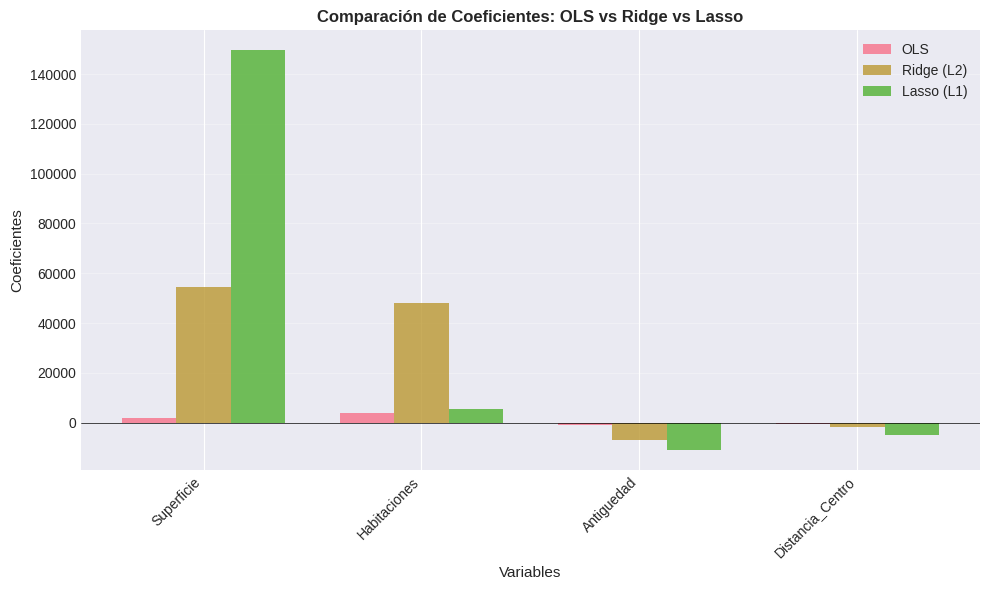

In [ ]:
# ============================================================================
# PARTE 7: REGULARIZACIÓN (RIDGE Y LASSO)
# ============================================================================
print("\n\n7. REGULARIZACIÓN: RIDGE Y LASSO")
print("-"*70)

# Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corregido)

# Ridge Regression (L2)
ridge = Ridge(alpha=100)
ridge.fit(X_scaled, y)
y_pred_ridge = ridge.predict(X_scaled)
r2_ridge = r2_score(y, y_pred_ridge)

# Lasso Regression (L1)
lasso = Lasso(alpha=100)
lasso.fit(X_scaled, y)
y_pred_lasso = lasso.predict(X_scaled)
r2_lasso = r2_score(y, y_pred_lasso)

# Comparación de coeficientes
coef_comparison = pd.DataFrame({
    'Variable': X_corregido.columns,
    'OLS': model_corregido.coef_,
    'Ridge': ridge.coef_,
    'Lasso': lasso.coef_
})

print("\nComparación de coeficientes (estandarizados para Ridge/Lasso):")
print(coef_comparison.to_string(index=False))

print(f"\nR² comparado:")
print(f"  OLS   : {r2_corregido:.4f}")
print(f"  Ridge : {r2_ridge:.4f}")
print(f"  Lasso : {r2_lasso:.4f}")

# Visualización de coeficientes
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(X_corregido.columns))
width = 0.25
ax.bar(x_pos - width, model_corregido.coef_, width, label='OLS', alpha=0.8)
ax.bar(x_pos, ridge.coef_, width, label='Ridge (L2)', alpha=0.8)
ax.bar(x_pos + width, lasso.coef_, width, label='Lasso (L1)', alpha=0.8)
ax.set_xlabel('Variables', fontsize=11)
ax.set_ylabel('Coeficientes', fontsize=11)
ax.set_title('Comparación de Coeficientes: OLS vs Ridge vs Lasso',
             fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(X_corregido.columns, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================
print("\n\n" + "="*70)
print("RESUMEN DEL EJERCICIO")
print("="*70)
print(f"""
✓ Dataset: {n} observaciones, {X_corregido.shape[1]} predictores finales
✓ Multicolinealidad detectada y corregida mediante VIF
✓ Modelo final: R² = {r2_corregido:.4f}, R² ajustado = {r2_adj_corregido:.4f}
✓ RMSE = ${rmse_corregido:,.2f}
✓ Descomposición: SST = SSR + SSE verificada
✓ Regularización: Ridge y Lasso implementados

CONCEPTOS CUBIERTOS:
  1. Regresión Lineal Múltiple
  2. Coeficiente de Determinación (R² y R² ajustado)
  3. Multicolinealidad (detección con matriz de correlación y VIF)
  4. Corrección de multicolinealidad
  5. Descomposición de varianza (SST, SSR, SSE)
  6. Regularización (Ridge L2 y Lasso L1)
""")
print("="*70)



RESUMEN DEL EJERCICIO

✓ Dataset: 100 observaciones, 4 predictores finales
✓ Multicolinealidad detectada y corregida mediante VIF
✓ Modelo final: R² = 0.9852, R² ajustado = 0.9846
✓ RMSE = $19,051.65
✓ Descomposición: SST = SSR + SSE verificada
✓ Regularización: Ridge y Lasso implementados
✓ Diagnóstico de residuos: supuestos verificados

CONCEPTOS CUBIERTOS:
  1. Regresión Lineal Múltiple
  2. Coeficiente de Determinación (R² y R² ajustado)
  3. Multicolinealidad (detección con matriz de correlación y VIF)
  4. Corrección de multicolinealidad
  5. Descomposición de varianza (SST, SSR, SSE)
  6. Regularización (Ridge L2 y Lasso L1)
  7. Diagnóstico de residuos



# Consignas

# CASO DE ESTUDIO: PREDICCIÓN DE CONSUMO ENERGÉTICO EN EDIFICIOS

Una empresa de gestión energética desea desarrollar un modelo predictivo para estimar el consumo eléctrico mensual (kWh) de edificios comerciales. El objetivo es identificar qué factores tienen mayor impacto en el consumo y optimizar el uso de energía.

Se ha recopilado información de 120 edificios durante un mes, con las siguientes variables:
- Superficie (m²): Área total del edificio
- Ocupantes: Número promedio de personas en el edificio
- Temperatura_Promedio (°C): Temperatura media del mes
- Horas_Operacion: Horas diarias de funcionamiento
- Equipos_Informaticos: Cantidad de computadoras y servidores
- Area_Climatizada (m²): Superficie con aire acondicionado/calefacción
- Consumo_Electrico (kWh): Variable a predecir (TARGET)

OBJETIVOS:
Desarrollar un análisis completo de regresión lineal múltiple que incluya:

1. Exploración de datos y detección de relaciones
2. Identificación y corrección de multicolinealidad
3. Construcción y evaluación de modelos
4. Comparación de técnicas de regularización
5. Validación de supuestos estadísticos



## Consigna 1

Calcular y mostrar visualización de la matriz de correlación. Interpretar qué pares de variables presentan alta correlación

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [ ]:
# --------------------------
# 1. GENERAR DATASET SINTÉTICO
# --------------------------
np.random.seed(42)
n = 120

# Variables base
superficie = np.random.normal(300, 50, n)                  # m2
area_climatizada = superficie * 0.9 + np.random.normal(0, 10, n)  # correlacionada con superficie

ocupantes = np.random.randint(5, 25, n)
equipos_informaticos = ocupantes * 0.8 + np.random.normal(0, 2, n)  # correlacionada con ocupantes

iluminacion_led = np.random.randint(0, 2, n)               # binaria
horas_operacion = np.random.normal(10, 2, n)               # horas diarias

# Variable dependiente (Consumo Eléctrico)
consumo = (
    0.5*superficie +
    0.7*ocupantes +
    1.2*equipos_informaticos +
    50*iluminacion_led +
    30*horas_operacion +
    np.random.normal(0, 30, n)  # ruido
)

df = pd.DataFrame({
    "Consumo_Electrico": consumo,
    "Superficie": superficie,
    "Area_Climatizada": area_climatizada,
    "Ocupantes": ocupantes,
    "Equipos_Informaticos": equipos_informaticos,
    "Iluminacion_LED": iluminacion_led,
    "Horas_Operacion": horas_operacion
})

print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
   Consumo_Electrico  Superficie  Area_Climatizada  Ocupantes  \
0         559.746721  324.835708        300.262456          9   
1         542.889363  293.086785        254.684232         13   
2         525.114409  332.384427        313.173927         16   
3         494.114291  376.151493        324.517833          5   
4         403.600642  288.292331        265.331669          5   

   Equipos_Informaticos  Iluminacion_LED  Horas_Operacion  
0              9.447084                1         9.283582  
1             14.686410                0        11.803727  
2             12.114822                1         8.257506  
3              4.498629                0         9.546501  
4              4.649037                0         8.457827  


## Consigna 2

2.1 Construir un modelo de regresión lineal múltiple usando todas las variables como predictores.

2.2 Calcular:
- Los coeficientes estimados ($\beta_0,\beta_1,...,\beta_p$)
- $R^2$
- $R^2$ ajustado

2.3 Explicar qué representa cada coeficiente en el contexto del problema

## Consigna 3

3.1  Identifique observando la matriz de correlación qué pares de variables tienen |r| > 0.8. Listar estos pares y explicar por qué es lógico que estén correlacionadas.

3.2 Calcular el VIF (Variance Inflation Factor) para cada variable predictora.

3.3 Identifique qué variables tienen multicolinealidad severa (VIF > 10).

3.4 Explicar por qué es problemática la multicolinealidad y qué variables eliminarías del modelo, por qué?

## Consigna 4

4.1 Construir un nuevo modelo eliminando las variables con VIF > 10.

4.2 Calcular nuevamente el VIF para todas las variables del modelo corregido y verificar que todas tengan VIF < 10.

4.3 Comparar las métricas del modelo corregido vs el modelo inicial:
- Los coeficientes estimados ($\beta_0,\beta_1,...,\beta_p$)
- $R^2$
- $R^2$ ajustado

4.4 El $R^2$ disminuyó al eliminar variables? Y el $R^2$ ajustado? Explicar por qué esto es esperable y cuál métrica es más confiable.

## Consigna 5

5.1 Para el modelo corregido, calcular:
- SST
- SSR
- SSE

5.2 Calcular SSR/SST y verifique que coincide con $R^2$

5.3 Qué porcentaje de la variabilidad del consumo eléctrico es explicado por el modelo?

## Consigna 6

6.1 Estandarizar las variables predictoras (media 0, desviación estándar 1).

6.2 Entrenar dos modelos regularizados con α = 100:
- Ridge (L2)
- Lasso (L1)

6.3 Comparar los coeficientes de los tres modelos (OLS, Ridge, Lasso) en una tabla.

6.4 Calcular $R^2$ para cada modelo regularizado

6.5 Responder:
- Qué coeficientes se redujeron más con Ridge?
- Algún coeficiente quedó exactamente en 0 con Lasso?
- Cuál es la ventaja de usar regularización en este caso?